In [3]:
import os
from tensorflow.keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain
import csv

In [4]:
MODEL = 'GoogleNews-vectors-negative300.bin'

path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')

unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Austria', 0.7461062669754028),
 ('German', 0.7178750038146973),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.634294867515564)]

As you could see above, most similar to a bunch of countries are some other countries.

In [6]:
model.most_similar(positive=['Annita_Kirsten'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Braustolz_GmbH', 0.7545095682144165),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307887673377991),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067489624023438),
 ('BMW_###si_1min_##.###secs', 0.7050351500511169),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925466656684875),
 ('Severin_Freund', 0.6898956298828125),
 ('However_Joern_Lauterjung', 0.6885738968849182)]

Now we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [7]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])]

In [9]:
import random

positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['Casualty_Underwriters',
 'consultancy_Analysys_Mason',
 'TASMANIANS',
 'gone_astray']

In [10]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [12]:
from sklearn import svm

TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.82993197278911,
 [('Kosovo', 1),
  ('AWACS_surveillance_planes', 0),
  ('Aruba', 1),
  ('Gaza_Strip', 1),
  ('Ukraine', 0),
  ('Greece', 0)])

Precision is 99.8%, which is really good.

In [14]:
all_predictions = clf.predict(model.syn0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [15]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['South_Korea',
 'UAE',
 'Netherlands',
 'Dutch',
 'Austria',
 'Denmark',
 'Afghan',
 'Chad',
 'Lebanon',
 'Syria']

In [16]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

Quick sanity check to see what is similar to Canada:

In [17]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


Ranking countries for a specific term:



In [18]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [19]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

In [23]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


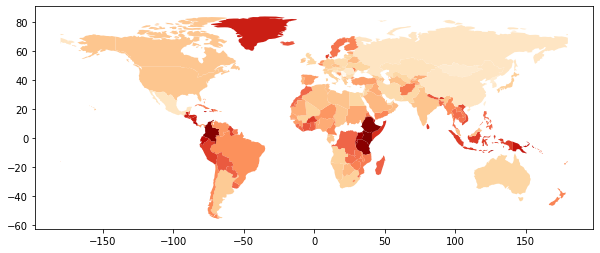

In [24]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')

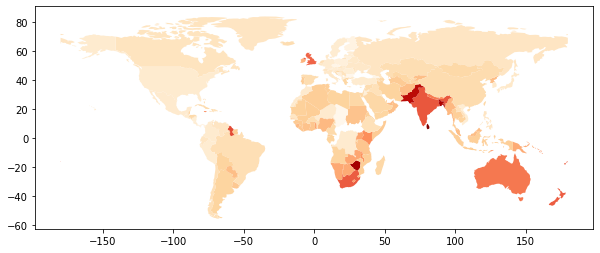

In [25]:
map_term('cricket')

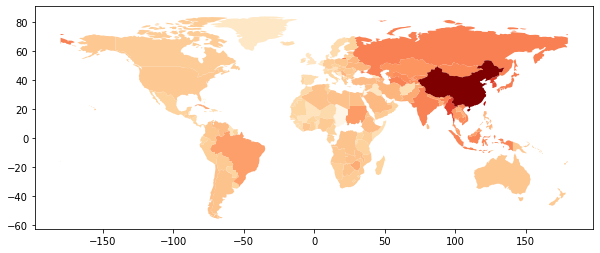

In [26]:
map_term('China')

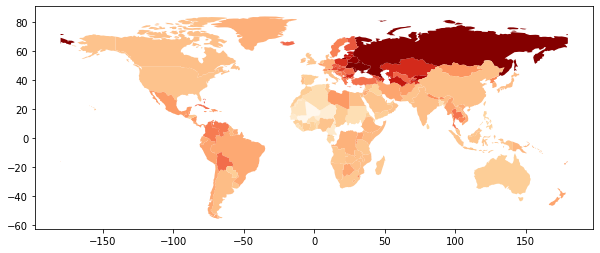

In [27]:
map_term('vodka')